In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imgaug as ia
import torch
import pandas as pd
import os
import glob
import os
import warnings

In [29]:
def bb_midpoint_to_corner(bb):
    label = bb[0]
    x1 = bb[1] - bb[3]/2
    x2 = bb[1] + bb[3]/2
    y1 = bb[2] - bb[4]/2
    y2 = bb[2] + bb[4]/2
    # A: area will only be used for sorting
    area = bb[3]*bb[4]
    corner_list = [label, x1, x2, y1, y2, area]
    return np.array(corner_list)

def open_yolo_sort(path, image_name):
    try:
        image = cv2.imread(path + image_name)
        shape = image.shape
        width = shape[1]
        height = shape[0]
        label = path + os.path.splitext(image_name)[0] + ".txt"
        boxes = np.genfromtxt(label, delimiter=' ')
        bb = boxes
        # reshaping the np array is necessary in case a file with a single box is read
        boxes = boxes.reshape(boxes.size//5, 5)
        #print(boxes.shape)
        boxes = np.apply_along_axis(bb_midpoint_to_corner, axis=1, arr=boxes)
        # A: sorting by area
        boxes = boxes[boxes[:, 5].argsort()]
        # A: reversing the sorted list so bigger areas come first
        boxes = boxes[::-1]
        return image, boxes, width, height
    except Exception as e:
        #print(e)
        print(image_name)
        return image, None, None, None

def create_segclass(image_path, save_path, image_name):
    image, bb, w, h = open_yolo_sort(image_path, image_name)
    image_copy = image.copy()*0 
    if bb is not None:       
        for label, x1, x2, y1, y2, area in bb:
            # A: the white outline with four pixels of thickness
            cv2.rectangle(image_copy, (int(x1*w), int(y1*h)), (int(x2*w), int(y2*h)), (255, 255, 255), 4)
            # A: the class coded filing, specified by -1
            cv2.rectangle(image_copy, (int(x1*w), int(y1*h)), (int(x2*w), int(y2*h)), colors[int(label)], -1)
        image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
        cv2.imwrite(save_path + os.path.splitext(image_name)[0] + ".png", image_copy)
    else:
        cv2.imwrite(save_path + os.path.splitext(image_name)[0] +".png", image_copy)

def create_segclass_filtered(image_path, save_path, image_name, filter_list):
    image, bb, w, h = open_yolo_sort(image_path, image_name)
    image_copy = image.copy()*0 
    if bb is not None:       
        for label, x1, x2, y1, y2, area in bb:
            if label in filter_list:
                # A: the white outline with four pixels of thickness
                cv2.rectangle(image_copy, (int(x1*w), int(y1*h)), (int(x2*w), int(y2*h)), (255, 255, 255), 4)
                # A: the class coded filing, specified by -1
                cv2.rectangle(image_copy, (int(x1*w), int(y1*h)), (int(x2*w), int(y2*h)), colors[int(label)], -1)
        image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
        cv2.imwrite(save_path + os.path.splitext(image_name)[0] + ".png", image_copy)
    else:
        cv2.imwrite(save_path + os.path.splitext(image_name)[0] +".png", image_copy)

#colors = [  (128, 0, 0),     # Chave seccionadora lamina (Aberta)
#            (0, 128, 0),     # Chave seccionadora lamina (Fechada)
#            (128, 128, 0),   # Chave seccionadora tandem (Aberta)
#            (0, 0, 128),     # Chave seccionadora tandem (Fechada)
#            (128, 0, 128),   # Disjuntor
#            (0, 128, 128),   # Fusivel
#            (128, 128, 128), # Isolador disco de vidro
#            (64, 0, 0),      # Isolador pino de porcelana
#            (192, 0, 0),     # Mufla
#            (64, 128, 0),    # Para-raio
#            (192, 128, 0),   # Religador
#            (64, 0, 128),    # Transformador
#            (192, 0, 128),   # Transformador de Corrente (TC)
#            (64, 128, 128),  # Transformador de Potencial (TP) 
#         ]

colors = [(162, 0, 255), # Chave seccionadora lamina (Aberta)
         (97, 16, 162),   # Chave seccionadora lamina (Fechada)
         (81, 162, 0),    # Chave seccionadora tandem (Aberta)
         (48, 97, 165),   # Chave seccionadora tandem (Fechada)
         (121, 121, 121), # Disjuntor
         (255, 97, 178),  # Fusivel
         (154, 32, 121),  # Isolador disco de vidro
         (255, 255, 125), # Isolador pino de porcelana
         (162, 243, 162), # Mufla
         (143, 211, 255), # Para-raio
         (40, 0, 186),    # Religador
         (255, 182, 0),   # Transformador
         (138, 138, 0),   # Transformador de Corrente (TC)
         (162, 48, 0),    # Transformador de Potencial (TP)
         (162, 0, 96)     # Chave tripolar
         ] 

In [36]:
# paths = ["/home/jovyan/work/yolo_og/yolov3/Data/15_classes/train/",            # 2363
#         "/home/jovyan/work/yolo_og/yolov3/Data/15_classes/flir_train/",       # 1083
#         "/home/jovyan/work/yolo_og/yolov3/Data/15_classes/night_train/",      # 479
#         "/home/jovyan/work/yolo_og/yolov3/Data/15_classes/tripolares_train/", # 879
#         "/home/jovyan/work/yolo_og/yolov3/Data/15_classes/fake_night/"]       # 311

paths = ["../data/valid/"]

filter_list = [7] # isolador pino de porcelana
save_path = "../data/isolador_porcelana/valid/"

check_path = os.path.isdir(save_path)
if not check_path:
    os.makedirs(save_path)
    print("created folder: ", save_path) 
#label_path = "../data/labels_17class/"
for image_path in paths:
    file_list = os.path.join(os.path.join(image_path, "*.*"))
    image_list = []
    file_list = glob.glob(file_list)
    for name in file_list:
        if "txt" not in name:
            image_list.append(name.split("/")[-1])

    for file in image_list:
        create_segclass_filtered(image_path, save_path, file, filter_list)

created folder:  ../data/isolador_porcelana/valid/


In [28]:
# which classes we want to keep



In [ ]:
1081
20210713_150012.jpg
20210713_144845.jpg
IMG_20201215_140429_8.jpg

In [ ]:
Created dir /home/jovyan/work/deeplab/data/segmentation_train/
2749
FLIR6234_rgb.jpg
FLIR6230_rgb.jpg
FLIR6208_rgb.jpg
FLIR6951_rgb.jpg
FLIR6206_rgb.jpg
FLIR6212_rgb.jpg
FLIR6215_rgb.jpg
FLIR6211_rgb.jpg
FLIR6248_rgb.jpg
FLIR6911_rgb.jpg
FLIR6207_rgb.jpg
FLIR6224_rgb.jpg
FLIR6244_rgb.jpg
FLIR6213_rgb.jpg
FLIR7279_rgb.jpg
FLIR6217_rgb.jpg
FLIR8103_rgb_29kooNB.jpg
FLIR6239_rgb.jpg
FLIR6231_rgb.jpg
FLIR6251_rgb.jpg
FLIR6229_rgb.jpg
FLIR6240_rgb.jpg
FLIR6227_rgb.jpg
FLIR6247_rgb.jpg
FLIR6216_rgb.jpg
FLIR6249_rgb.jpg
FLIR7285_rgb.jpg
FLIR6243_rgb.jpg
FLIR6233_rgb.jpg
FLIR6241_rgb.jpg
FLIR6225_rgb.jpg
FLIR6228_rgb.jpg
FLIR6246_rgb.jpg
FLIR6232_rgb.jpg
FLIR6237_rgb.jpg
FLIR6252_rgb.jpg
FLIR6220_rgb.jpg
FLIR6242_rgb.jpg
FLIR6235_rgb.jpg
FLIR6223_rgb.jpg
FLIR6238_rgb.jpg
FLIR6222_rgb.jpg
FLIR6218_rgb.jpg
FLIR6214_rgb.jpg
FLIR6219_rgb.jpg
FLIR6209_rgb.jpg
FLIR7393_rgb_TiS9xrQ.jpg
FLIR6221_rgb.jpg
FLIR6245_rgb.jpg
FLIR6226_rgb.jpg
FLIR6250_rgb.jpg

In [24]:
for image in image_list[916:]:
    print(image)

20210811_095738(0).jpg
FLIR1592_rgb.jpg
FLIR5933_rgb.jpg
20210811_095746(0).jpg
FLIR5953_rgb.jpg
202107131447265099453.jpg
20210805_100133.jpg
20210721_113736.jpg
20210811_094309(0).jpg
FLIR1873_rgb.jpg
FLIR1389_rgb.jpg
20210713_144843.jpg
FLIR5940_rgb.jpg
FLIR1271_rgb.jpg
20210811_095715.jpg
20210811_091939.jpg
FLIR1938_rgb.jpg
20210811_095439.jpg
20210721_113656.jpg
IMG_0956.JPEG
FLIR0406_rgb.jpg


In [148]:
# A: reading the image
object_path = "/home/jovyan/work/yolo_og/yolov3/Data/14_classes/flir_train/"
save_path = "./segmentation_class/"
img_name = "FLIR6106_rgb"
img, bb, w, h = open_yolo_sort(object_dir, img_name)

'NoneType' object has no attribute 'shape'
FLIR6106_rgb


0.08472467239600001
0.003808575
0.001464875


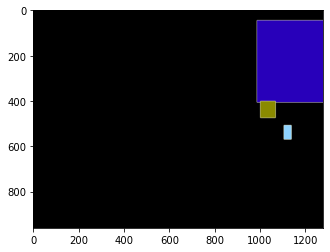

True

In [94]:
img_copy = img.copy()*0
for label, x1, x2, y1, y2, area in bb:
    print(area)
    # A: the whiteish outline with four pixels of thickness
    cv2.rectangle(img_copy, (int(x1*w), int(y1*h)), (int(x2*w), int(y2*h)), (224, 224, 192), 4)
    # A: the class coded filing, specified by -1
    cv2.rectangle(img_copy, (int(x1*w), int(y1*h)), (int(x2*w), int(y2*h)), colors[int(label)], -1)
# A: displaying the images
#fig = plt.figure(figsize=(10,4))
#ax = fig.add_subplot()
#ax.imshow(img_copy)
#plt.show()
cv2.imwrite(save_path + img_name + ".jpg", img_copy)

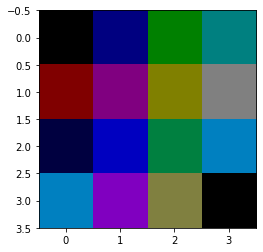

In [287]:
image = cv2.imread("target.png")

# A: displaying the images
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot()
ax.imshow(image)
plt.show()

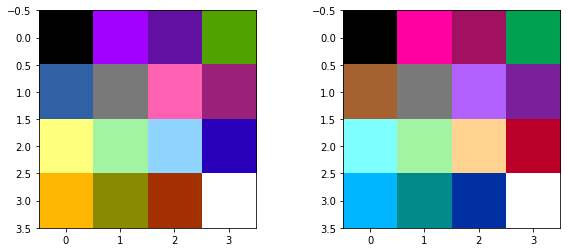

True

In [362]:
image2 = cv2.imread("target2.png")
image =   np.asarray([[  (0, 0, 0),
                         (162, 0, 255), # Chave seccionadora lamina (Aberta)
                         (97, 16, 162),   # Chave seccionadora lamina (Fechada)
                         (81, 162, 0)],    # Chave seccionadora tandem (Aberta)
                         [(48, 97, 165),   # Chave seccionadora tandem (Fechada)
                         (121, 121, 121), # Disjuntor
                         (255, 97, 178),  # Fusivel
                         (154, 32, 121)],  # Isolador disco de vidro
                         [(255, 255, 125), # Isolador pino de porcelana
                         (162, 243, 162), # Mufla
                         (143, 211, 255), # Para-raio
                         (40, 0, 186)],    # Religador
                         [(255, 182, 0),   # Transformador
                         (138, 138, 0),   # Transformador de Corrente (TC)
                         (162, 48, 0),
                         (255, 255, 255)]])    # Transformador de Potencial (TP)
# A: displaying the images
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.imshow(image)
ax = fig.add_subplot(122)
ax.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite("target_bgr.png", image2)
cv2.imwrite("target_rgb.png", cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))

In [225]:
from collections import namedtuple

CustomClass = namedtuple('CustomClass', ['name', 'id', 'color'])
classes = [CustomClass('background',          255, (0, 0, 0)),      # Background
           CustomClass('c. lamina (aberta)',  0,  (128, 0, 0)),    # Chave seccionadora lamina (Aberta)
           CustomClass('c. lamina (fechada)', 1,  (0, 128, 0)),    # Chave seccionadora lamina (Fechada)
           CustomClass('c. tandem (aberta)',  2,  (128, 128, 0)),  # Chave seccionadora tandem (Aberta)
           CustomClass('c. tandem (fechada)', 3,  (0, 0, 128)),    # Chave seccionadora tandem (Fechada)
           CustomClass('disjuntor',           4,  (128, 0, 128)),  # Disjuntor
           CustomClass('fusivel',             5,  (0, 128, 128)),  # Fusivel
           CustomClass('isolador vidro',      6,  (128, 128, 128)),# Isolador disco de vidro
           CustomClass('isolador porcelana',  7,  (64, 0, 0)),     # Isolador pino de porcelana
           CustomClass('mufla',               8,  (192, 0, 0)),    # Mufla
           CustomClass('para-raio',           9,  (64, 128, 0)),   # Para-raio
           CustomClass('religador',           10, (192, 128, 0)),  # Religador
           CustomClass('transformador',       11, (64, 0, 128)),   # Transformador
           CustomClass('TC',                  12, (192, 0, 128)),  # Transformador de Corrente (TC)
           CustomClass('TP',                  13, (64, 128, 128))  # Transformador de Potencial (TP) 
          ]

id_to_color = [c.color for c in classes]
color_to_id = [c.id for c in classes]

In [333]:
def get_labels():
    """Load the mapping that associates classes with label colors.
       Our electrical substation dataset has 14 objects + background.
    Returns:
        np.ndarray with dimensions (15, 3)
    """
    return np.asarray([ (0, 0, 0),       # Background
                        (162, 0, 255),   # Chave seccionadora lamina (Aberta)
                        (97, 16, 162),   # Chave seccionadora lamina (Fechada)
                        (81, 162, 0),    # Chave seccionadora tandem (Aberta)
                        (48, 97, 165),   # Chave seccionadora tandem (Fechada)
                        (121, 121, 121), # Disjuntor
                        (255, 97, 178),  # Fusivel
                        (154, 32, 121),  # Isolador disco de vidro
                        (255, 255, 125), # Isolador pino de porcelana
                        (162, 243, 162), # Mufla
                        (143, 211, 255), # Para-raio
                        (40, 0, 186),    # Religador
                        (255, 182, 0),   # Transformador
                        (138, 138, 0),   # Transformador de Corrente (TC)
                        (162, 48, 0)]    # Transformador de Potencial (TP)
                        )

In [339]:
def decode_target(label_mask):
    """Decode segmentation class labels into a color image
    Args:
        label_mask (np.ndarray): an (M,N) array of integer values denoting
          the class label at each spatial location.
    Returns:
        (np.ndarray): the resulting decoded color image.
    """
    label_colors = get_labels()
    r = label_mask.copy()
    g = label_mask.copy()
    b = label_mask.copy()
    for l in range(0, len(label_colors)):
        r[label_mask == l] = label_colors[l, 0]
        g[label_mask == l] = label_colors[l, 1]
        b[label_mask == l] = label_colors[l, 2]
    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
    rgb[:, :, 0] = r
    rgb[:, :, 1] = g
    rgb[:, :, 2] = b
    return rgb

In [343]:
def encode_target(mask):
    """Encode segmentation label images as classes
    Args:
        mask (np.ndarray): raw segmentation label image of dimension
          (M, N, 3), in which the classes are encoded as colors.
    Returns:
        (np.ndarray): class map with dimensions (M,N), where the value at
        a given location is the integer denoting the class index.
    """
    mask = mask.astype(int)
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
    for i, label in enumerate(get_labels()):
        label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = i
    label_mask = label_mask.astype(int)
    return label_mask

en = encode_target(image)
en

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14,  0]])

In [344]:
decode_target(en)

array([[[  0.,   0.,   0.],
        [162.,   0., 255.],
        [ 97.,  16., 162.],
        [ 81., 162.,   0.]],

       [[ 48.,  97., 165.],
        [121., 121., 121.],
        [255.,  97., 178.],
        [154.,  32., 121.]],

       [[255., 255., 125.],
        [162., 243., 162.],
        [143., 211., 255.],
        [ 40.,   0., 186.]],

       [[255., 182.,   0.],
        [138., 138.,   0.],
        [162.,  48.,   0.],
        [  0.,   0.,   0.]]])

In [227]:
color_to_id(image)

TypeError: 'list' object is not callable

In [352]:
image

array([[[  0,   0,   0],
        [162,   0, 255],
        [ 97,  16, 162],
        [ 81, 162,   0]],

       [[ 48,  97, 165],
        [121, 121, 121],
        [255,  97, 178],
        [154,  32, 121]],

       [[255, 255, 125],
        [162, 243, 162],
        [143, 211, 255],
        [ 40,   0, 186]],

       [[255, 182,   0],
        [138, 138,   0],
        [162,  48,   0],
        [255, 255, 255]]])